# Emotion Classification
## DATASCI 281 - Computer Vision
### Students: Diego Moss, Subhasis Das, Priscilla Miller

## Import Libraries/Modules

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterSampler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import utils
import preprocessing_functions as pf
from skimage.filters import gabor
import cv2
from skimage.feature import hog

## Feature Extraction Functions

In [2]:
# feature extraction functions
# extract sobel edge
def sobel_edges(images_array):
    n_images = images_array.shape[0]
    processed = np.zeros(images_array.shape[:3], dtype=np.uint8)
    for i in range(n_images):
        # histogram equalization
        img_eq = cv2.equalizeHist(images_array[i])
        
        # Apply Sobel edge detection
        # Sobel in X direction
        sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
        # Sobel in Y direction
        sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
        # Combine both gradients
        sobel_combined = cv2.magnitude(sobelx, sobely)
        processed[i] = sobel_combined
    processed = processed.reshape(processed.shape[0], -1)
    return processed

# extract gabor
def compute_gabor(images, params={"theta": 90, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi}):
    n_images = len(images)
    gabor_features = []
    
    for i in range(n_images):
        # Get current image
        image = images[i]

        # Apply Gabor filter
        response, gabor_image = gabor(image, 
                           frequency=params["frequency"], 
                           theta=np.deg2rad(params["theta"]),
                           sigma_x=params["sigma"], 
                           sigma_y=params["sigma"],
                           bandwidth=params["bandwidth"], 
                           offset=params["offset"])
        
        # Store features
        gabor_features.append(response.flatten())
    
    return np.array(gabor_features), gabor_image

# extract HOG
def extract_hog_features(images, orientations=18, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                 block_norm='L2-Hys', channel=None):
    n_samples = len(images)
    
    # Process first image to get feature dimensions
    fd = hog(images[0], 
             orientations=orientations,
             pixels_per_cell=pixels_per_cell,
             cells_per_block=cells_per_block,
             block_norm=block_norm,
             feature_vector=True,
             channel_axis=channel)
    
    # Initialize feature array
    features = np.zeros((n_samples, len(fd)))
    features[0] = fd
    
    # Process remaining images
    for i in range(1, n_samples):
        features[i] = hog(images[i],
                         orientations=orientations,
                         pixels_per_cell=pixels_per_cell,
                         cells_per_block=cells_per_block,
                         block_norm=block_norm,
                         feature_vector=True,
                         channel_axis=channel)
    
    return features

# Preprocessing function 
def feature_preprocessing(images, norm=False, gray=False, contrast=False):
    preprocessed_images = images
    if norm:
        preprocessed_images = pf.normalize_images(preprocessed_images)
    if gray:
        preprocessed_images = pf.convert_to_grayscale(preprocessed_images)
    if contrast:
        preprocessed_images = pf.apply_contrast_normalization(preprocessed_images)
    return preprocessed_images

## PCA Functions

In [3]:
# combine feature vectors and apply PCA function
def combine_and_run_pca(*feature_vectors, n_components=None):

    if len(feature_vectors) == 0:
        raise ValueError("At least one feature vector must be provided")
    
    # Ensure all inputs are numpy arrays
    feature_vectors = [np.asarray(fv) for fv in feature_vectors]
    
    # Check if all feature vectors have the same number of samples
    n_samples = feature_vectors[0].shape[0]
    for i, fv in enumerate(feature_vectors):
        if fv.shape[0] != n_samples:
            raise ValueError(f"Feature vector {i} has {fv.shape[0]} samples, but {n_samples} were expected")
    
    # Concatenate the feature vectors along the feature axis
    combined_features = np.hstack(feature_vectors)
    print(f"Combined feature shape: {combined_features.shape}")
    
    # Calculate total feature dimensions
    total_dims = sum(fv.shape[1] for fv in feature_vectors)
    print(f"Feature dimensions: {[fv.shape[1] for fv in feature_vectors]}, total: {total_dims}")
    
    # Initialize and fit PCA
    if n_components is None:
        n_components = min(combined_features.shape)
    
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(combined_features)
    
    return pca, transformed_data


# Plot explained variance
def plot_pca_explained_variance(pca, save_path=None, show_plot=True, figsize=(10, 6), dpi=300, features=None):

    fig, ax = plt.subplots(figsize=figsize)
    
    if features is not None:
        feature_string = " + ".join(str(x) for x in features)
        feature_string = " (" + feature_string + ")"
    else:
        feature_string = ""
        
    # Plot the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
            linestyle='-', label=f'Cumulative Variance{feature_string}')
    
    # Plot the explained variance for each component
    ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
          pca.explained_variance_ratio_, alpha=0.5, 
          label='Individual Explained Variance')
    
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Explained Variance')
    ax.set_title('PCA Explained Variance by Components')
    ax.legend(loc='lower right')
    ax.grid(True)
    
    # Add horizontal lines at common thresholds
    thresholds = [0.9, 0.95, 0.99]
    colors = ['r', 'g', 'b']

    for threshold, color in zip(thresholds, colors):
        ax.axhline(y=threshold, color=color, linestyle='-', alpha=0.3)

        # Find component number for this threshold
        if any(cumulative_variance >= threshold):
            components_needed = np.argmax(cumulative_variance >= threshold) + 1
            ax.annotate(f'{components_needed} components for {threshold*100}%',
                        xy=(components_needed, threshold),
                        xytext=(components_needed + 1, threshold + 0.02),
                        arrowprops=dict(arrowstyle='->'),
                        fontsize=9)
    
    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    
    # Show the plot if requested
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return fig, ax


# remove components function
def remove_pca_components(pca_model, transformed_data, method='threshold', value=0.95):

    cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
    
    if method == 'threshold':
        if not (0 < value <= 1):
            raise ValueError("Threshold value must be between 0 and 1")
        
        # Find how many components we need to reach the variance threshold
        if any(cumulative_variance >= value):
            n_components = np.argmax(cumulative_variance >= value) + 1
            variance_explained = cumulative_variance[n_components-1]
        else:
            n_components = len(pca_model.explained_variance_ratio_)
            variance_explained = cumulative_variance[-1]
            print(f"Warning: Cannot reach {value*100:.1f}% variance threshold. Using all {n_components} components.")
        
    elif method == 'components':
        value = int(value)
        if not (0 < value <= transformed_data.shape[1]):
            raise ValueError(f"Number of components must be between 1 and {transformed_data.shape[1]}")
        
        n_components = value
        variance_explained = cumulative_variance[n_components-1] if n_components <= len(cumulative_variance) else 1.0
        
    else:
        raise ValueError("Method must be 'threshold' or 'components'")
    
    # Extract only the required components
    reduced_data = transformed_data[:, :n_components]
    
    print(f"Selected {n_components} out of {transformed_data.shape[1]} components")
    print(f"Variance explained: {variance_explained:.4f} ({variance_explained*100:.2f}%)")
    print(f"Reduced data shape: {reduced_data.shape}")
    
    return reduced_data, n_components, variance_explained



## Load Dataset

In [4]:
# load shuffled and denoised images
train_images, train_labels, test_images, test_labels = utils.load_processed_data('preprocessed_data.pkl')

# label mapping
labels_dict = {0: 'surprise', 1: 'fear', 2: 'disgust', 3: 'happiness', 4: 'sadness', 5: 'anger', 6: 'neutral'}

# Adjust label values to be from 0 to 6
train_labels = train_labels - 1
test_labels = test_labels - 1


In [5]:
# set all images in grayscale
train_images = feature_preprocessing(train_images, norm=False, gray=True, contrast=False)
test_images = feature_preprocessing(test_images, norm=False, gray=True, contrast=False)

# break into training and validation sets
train_images, val_images, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.25, train_size=0.75, random_state=1234, shuffle=True)
y_test = test_labels


## Extract Features

In [6]:
# extract features
# training set
hog_features = extract_hog_features(train_images, channel=None)
gabor_features, _ = compute_gabor(train_images)
edge_features = sobel_edges(train_images)

# validation set
hog_features_val = extract_hog_features(val_images, channel=None)
gabor_features_val, _ = compute_gabor(val_images)
edge_features_val = sobel_edges(val_images)

# test set
hog_features_test = extract_hog_features(test_images, channel=None)
gabor_features_test, _ = compute_gabor(test_images)
edge_features_test = sobel_edges(test_images)

# normalize
gabor_features = gabor_features/255
edge_features = edge_features/255

gabor_features_val = gabor_features_val/255
edge_features_val = edge_features_val/255

gabor_features_test = gabor_features_test/255
edge_features_test = edge_features_test/255


## Run PCA and Remove Components

Combined feature shape: (9203, 28712)
Feature dimensions: [8712, 10000, 10000], total: 28712
Transformed data shape: (9203, 9203)


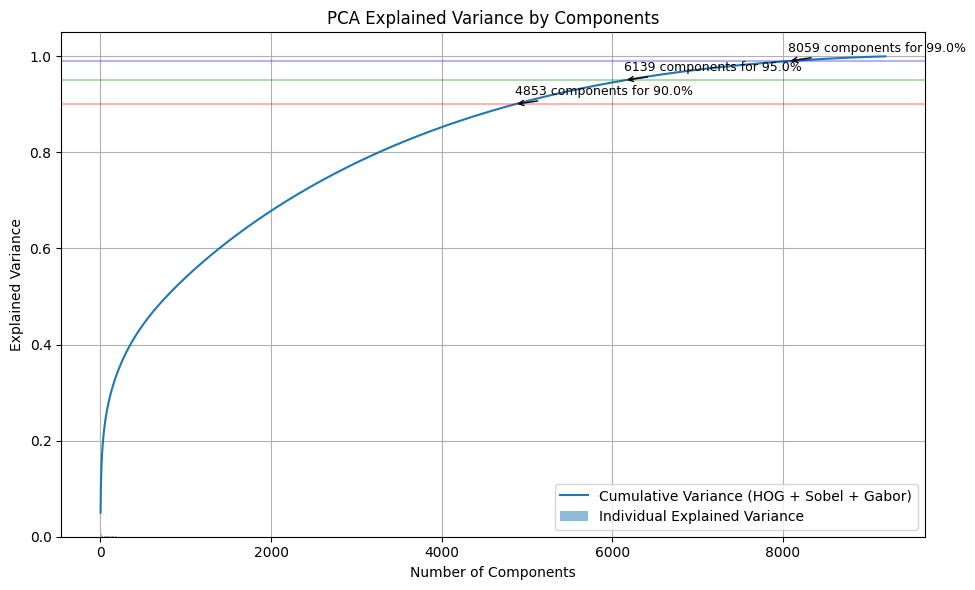

Selected 6139 out of 9203 components
Variance explained: 0.9500 (95.00%)
Reduced data shape: (9203, 6139)
Selected 6139 out of 9203 components
Variance explained: 0.9500 (95.00%)
Reduced data shape: (3068, 6139)
Selected 6139 out of 9203 components
Variance explained: 0.9500 (95.00%)
Reduced data shape: (3068, 6139)


In [7]:
# Run PCA on combined features
pca_model, transformed_data = combine_and_run_pca(
    hog_features,
    edge_features,
    gabor_features
)

print(f"Transformed data shape: {transformed_data.shape}")
# Plot the explained variance
plot_pca_explained_variance(pca_model, save_path='pca_explained_variance.png', features=["HOG", "Sobel", "Gabor"]);

# remove unnecessary components 
X_train, n_components, variance = remove_pca_components(
    pca_model, transformed_data, method='threshold', value=0.95
)

# Transform validation data using the existing PCA model
val_pca_transformed = pca_model.transform(np.hstack([
    hog_features_val,
    gabor_features_val,
    edge_features_val]))

X_val, _, _ = remove_pca_components(
    pca_model, 
    val_pca_transformed, 
    method='threshold',  
    value=0.95           
)

# Transform test data using the existing PCA model
test_pca_transformed = pca_model.transform(np.hstack([
    hog_features_test,
    gabor_features_test,
    edge_features_test]))

X_test, _, _ = remove_pca_components(
    pca_model, 
    test_pca_transformed, 
    method='threshold',  
    value=0.95           
)

## t-SNE

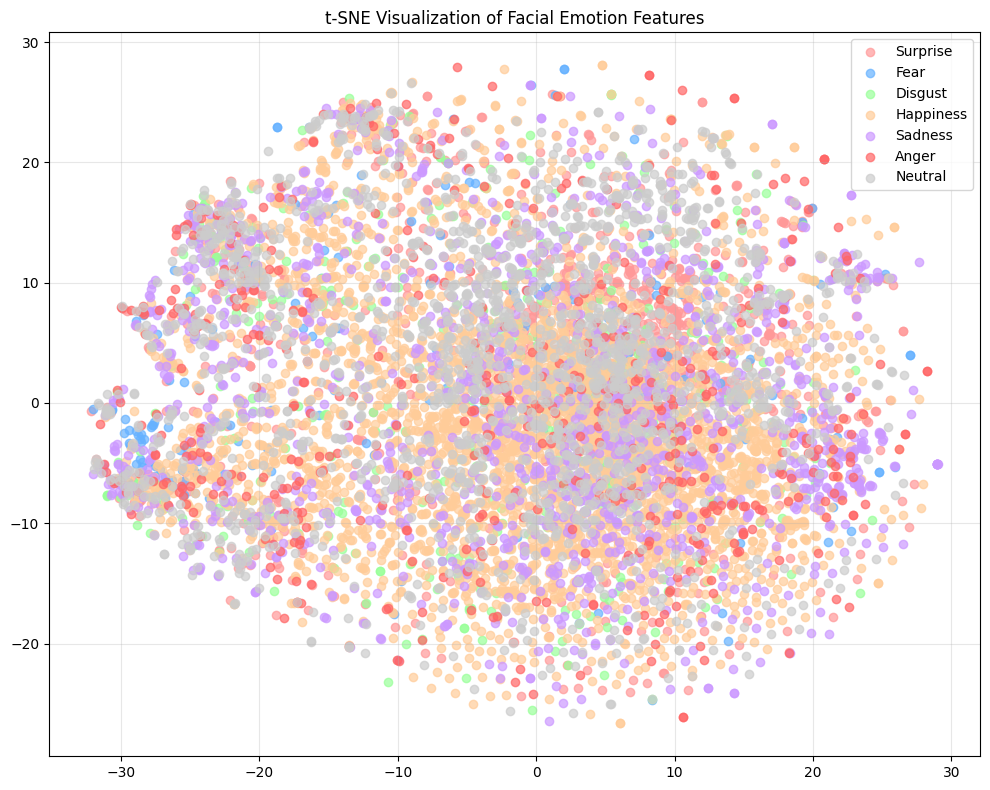

In [8]:
# tsne
# Apply t-SNE to the PCA-reduced features
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(X_train)

# Create scatter plot
plt.figure(figsize=(10, 8))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CC99FF', '#FF6666', '#CCCCCC']

# Map each label in your dictionary to a color
for i, (label_num, emotion) in enumerate(labels_dict.items()):
    # Plot points for this emotion
    idx = np.where(y_train == label_num)[0]
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], 
                c=colors[i % len(colors)], label=emotion.capitalize(), alpha=0.7)

plt.title('t-SNE Visualization of Facial Emotion Features')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_emotion_features.png', dpi=300)
plt.show()

## Check Shapes and Get Class Weights

In [9]:
# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

# Calculate class weights to correct for class imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


Shape of train images  (9203, 6139)
Shape of train labels  (9203,)
Shape of val images  (3068, 6139)
Shape of val labels  (3068,)
Shape of test images  (3068, 6139)
Shape of test labels  (3068,)


## Create Validation Subsets for Hyperparameters Search

In [10]:
# Create validation subsets for hyperparameter search
def create_val_subsets(val_x, val_y, n_subsets=3):
    val_x, val_y = shuffle(val_x, val_y, random_state=1234)
    subset_size = len(val_x) // n_subsets
    return [(val_x[d*subset_size:(d+1)*subset_size], val_y[d*subset_size:(d+1)*subset_size])
            for d in range(n_subsets)]

val_subsets = create_val_subsets(X_val, y_val, n_subsets=3)

## Baseline Model

In [11]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
verbose=1,
patience=3,
restore_best_weights=True)

In [12]:
tf.random.set_seed(1234)
np.random.seed(1234)

n_components = X_train.shape[1] 

baseline_model = tf.keras.Sequential([
    layers.InputLayer(shape=(n_components,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 emotions
])

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# print model summary
baseline_model.summary()

# train model on (X_train, y_train) data
baseline_model.fit(
    x=X_train,
    y=y_train,
    epochs=20,
    class_weight=class_weights,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

# evaluate the accuracy of model on (X_val, y_val)
mlp_val_accuracy = baseline_model.evaluate(X_val, y_val, verbose=0)[1]

print(f"\nBaseline validation data accuracy: {mlp_val_accuracy:.2%}")

# evaluate the accuracy of model on test data
baseline_test_accuracy = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nTest data accuracy: {baseline_test_accuracy:.2%}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,571,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,663 (6.01 MB)

 Trainable params: 1,574,151 (6.00 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2930 - loss: 2.2754 - val_accuracy: 0.1936 - val_loss: 2.3939
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9080 - loss: 0.2147 - val_accuracy: 0.3227 - val_loss: 2.1629
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9908 - loss: 0.0556 - val_accuracy: 0.3572 - val_loss: 2.1952
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9974 - loss: 0.0229 - val_accuracy: 0.3791 - val_loss: 2.3561
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 0.0129 - val_accuracy: 0.3787 - val_loss: 2.5466
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Baseline validation data accuracy: 32.27%

Test data accuracy: 34.09%


## Multi-Layer Perceptron

In [13]:
# Set seeds
tf.random.set_seed(1234)
np.random.seed(1234)


# Define hyperparameter space
param_dist = {
    'learning_rate': [1e-3, 1e-4],
    'dropout_rate': [0.3, 0.5, 0.7],
    'l2_reg': [0.001, 0.01],
    'hidden_units': [(128, 64), (256, 128, 64)]
}

param_list = list(ParameterSampler(param_dist, n_iter=18, random_state=1234))

# Search
best_score = -np.inf
best_params = None

for params in param_list:
    print(f"\nTesting: {params}")
    
    # Build model
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(shape=(X_train.shape[1],)))
    
    for units in params['hidden_units']:
        model.add(layers.Dense(units, activation='relu',
                               kernel_regularizer=regularizers.l2(params['l2_reg'])))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_rate']))
    
    model.add(layers.Dense(7, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    model.fit(X_train, y_train,
              epochs=10,
              class_weight=class_weights,
              verbose=0)
    
    # Evaluate on each val subset
    scores = []
    for X_val_sub, y_val_sub in val_subsets:
        score = model.evaluate(X_val_sub, y_val_sub, verbose=0)[1]
        scores.append(score)
    
    avg_score = np.mean(scores)
    print(f"Average val accuracy across subsets: {avg_score:.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = params

print(f"\nBest validation accuracy: {best_score:.4f}")
print(f"Best hyperparameters: {best_params}")



Testing: {'learning_rate': 0.0001, 'l2_reg': 0.01, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.3}
Average val accuracy across subsets: 0.1905

Testing: {'learning_rate': 0.001, 'l2_reg': 0.001, 'hidden_units': (128, 64), 'dropout_rate': 0.7}
Average val accuracy across subsets: 0.2270

Testing: {'learning_rate': 0.001, 'l2_reg': 0.01, 'hidden_units': (128, 64), 'dropout_rate': 0.3}
Average val accuracy across subsets: 0.1053

Testing: {'learning_rate': 0.0001, 'l2_reg': 0.01, 'hidden_units': (128, 64), 'dropout_rate': 0.3}
Average val accuracy across subsets: 0.1177

Testing: {'learning_rate': 0.0001, 'l2_reg': 0.001, 'hidden_units': (128, 64), 'dropout_rate': 0.3}
Average val accuracy across subsets: 0.1693

Testing: {'learning_rate': 0.001, 'l2_reg': 0.01, 'hidden_units': (128, 64), 'dropout_rate': 0.7}
Average val accuracy across subsets: 0.1494

Testing: {'learning_rate': 0.0001, 'l2_reg': 0.001, 'hidden_units': (256, 128, 64), 'dropout_rate': 0.3}
Average val accuracy acros

In [14]:
# Rebuild the model using best_params
mlp_model = tf.keras.Sequential()
mlp_model.add(layers.InputLayer(shape=(X_train.shape[1],)))

for units in best_params['hidden_units']:
    mlp_model.add(layers.Dense(units, activation='relu',
                                kernel_regularizer=regularizers.l2(best_params['l2_reg'])))
    mlp_model.add(layers.BatchNormalization())
    mlp_model.add(layers.Dropout(best_params['dropout_rate']))

mlp_model.add(layers.Dense(7, activation='softmax'))

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train on full training set
mlp_model.fit(X_train, y_train, epochs=30, class_weight=class_weights, validation_data=(X_val, y_val), callbacks=[early_stopping])


# evaluate the accuracy of model on test data
mlp_val_accuracy = mlp_model.evaluate(X_val, y_val, verbose=0)[1]
print(f"\nTest data accuracy: {mlp_val_accuracy:.2%}")

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1903 - loss: 3.2454 - val_accuracy: 0.0502 - val_loss: 3.6280
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4554 - loss: 2.3950 - val_accuracy: 0.1248 - val_loss: 3.1152
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7039 - loss: 1.8193 - val_accuracy: 0.2099 - val_loss: 3.0547
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8462 - loss: 1.4596 - val_accuracy: 0.3937 - val_loss: 2.8562
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9187 - loss: 1.2532 - val_accuracy: 0.2604 - val_loss: 3.5216
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9472 - loss: 1.1407 - val_accuracy: 0.3957 - val_loss: 2.9221
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9479 - loss: 1.1022 - val_accuracy: 0.3282 - val_loss: 3.3978
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.

Test data accuracy: 

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 800x600 with 0 Axes>

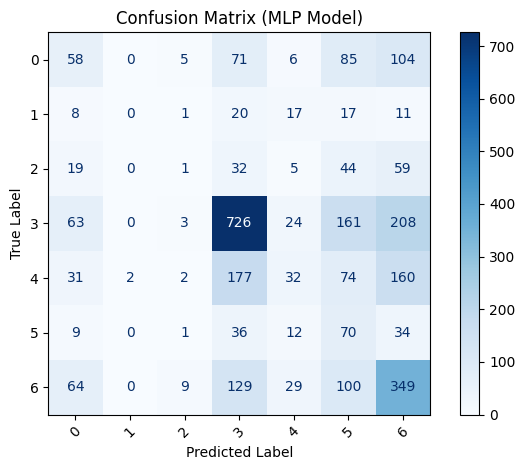

In [15]:
# Predict on test set
y_test_pred_probs = mlp_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (MLP Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

## Logistic Regression

In [16]:
# Logistic Regression with GridSearchCV
print("\nTraining Logistic Regression with GridSearchCV...")

# Define hyperparameter grid
C_values = [0.01, 0.1, 1, 10]

best_score = -np.inf
best_params = None

# Manual grid search over 'C'
for C in C_values:
    print(f"\nTesting C = {C}")
    scores = []

    # Train on training set, evaluate on each val subset
    model = LogisticRegression(C=C, max_iter=1000, solver='sag', class_weight=class_weights)

    model.fit(X_train, y_train)

    for X_val_sub, y_val_sub in val_subsets:
        y_pred = model.predict(X_val_sub)
        acc = accuracy_score(y_val_sub, y_pred)
        scores.append(acc)

    avg_score = np.mean(scores)
    print(f"Average val accuracy: {avg_score:.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

# Final model training on full training set with best C
print(f"\nBest hyperparameters: {best_params}, accuracy: {best_score:.4f}")
lr = LogisticRegression(C=best_params['C'], max_iter=1000, solver='sag', class_weight=class_weights)
lr.fit(X_train, y_train)

# Evaluate on validation and test sets
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

print("\nLogistic Regression Report (Validation):")
print(classification_report(y_val, y_val_pred_lr))

print("\nLogistic Regression Report (Test):")
print(classification_report(y_test, y_test_pred_lr))


Training Logistic Regression with GridSearchCV...

Testing C = 0.01
Average val accuracy: 0.4087

Testing C = 0.1
Average val accuracy: 0.4175

Testing C = 1
Average val accuracy: 0.4204

Testing C = 10
Average val accuracy: 0.4097

Best hyperparameters: {'C': 1}, accuracy: 0.4204

Logistic Regression Report (Validation):
              precision    recall  f1-score   support

           0       0.29      0.54      0.38       351
           1       0.05      0.03      0.04        73
           2       0.12      0.08      0.10       182
           3       0.58      0.81      0.68      1148
           4       0.27      0.04      0.07       478
           5       0.20      0.52      0.29       193
           6       0.48      0.07      0.12       643

    accuracy                           0.42      3068
   macro avg       0.28      0.30      0.24      3068
weighted avg       0.42      0.42      0.36      3068


Logistic Regression Report (Test):
              precision    recall  f1-scor

<Figure size 800x600 with 0 Axes>

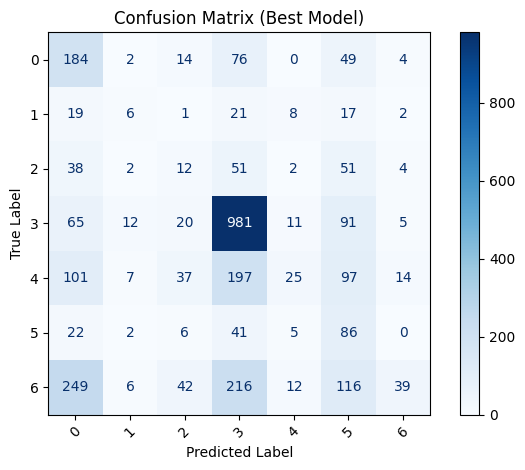

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

## ROC Curve for Logistic Regression Model

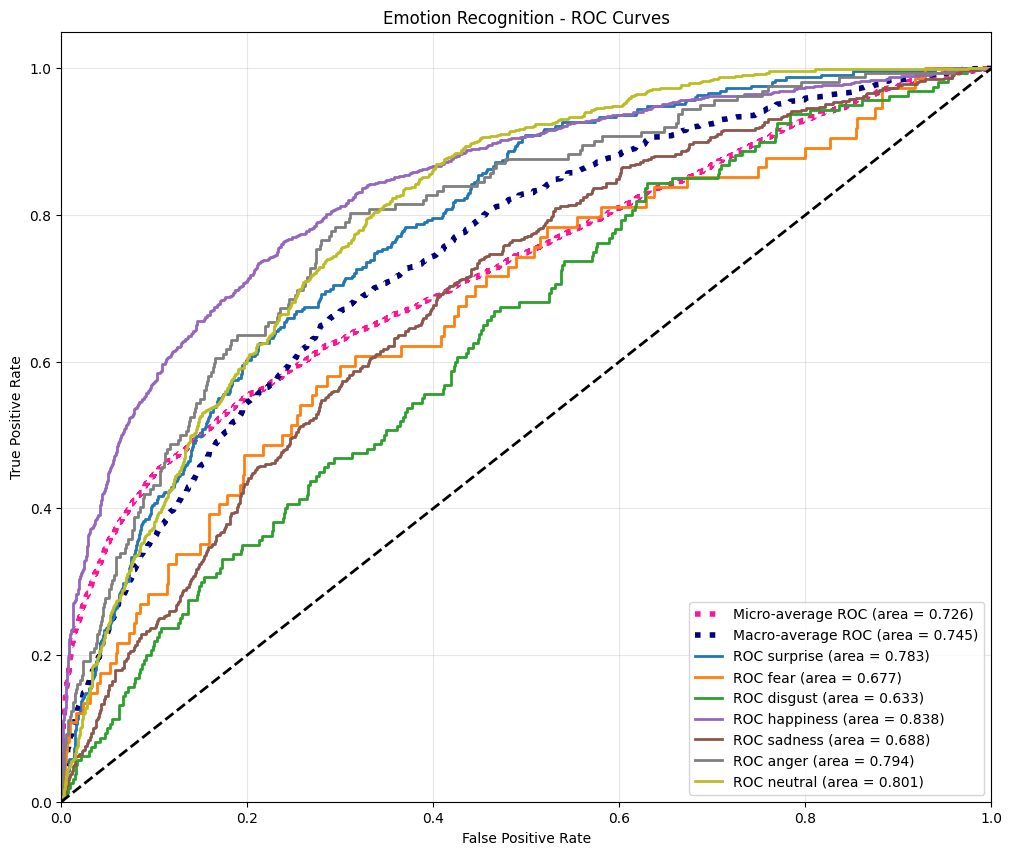

One-vs-Rest AUC scores:
surprise: 0.7834
fear: 0.6766
disgust: 0.6329
happiness: 0.8379
sadness: 0.6883
anger: 0.7942
neutral: 0.8011
Micro-average AUC: 0.7260
Macro-average AUC: 0.7451


In [18]:
# Get probability predictions
y_val_proba_lr = lr.predict_proba(X_val)
y_test_proba_lr = lr.predict_proba(X_test)

# Get the number of classes
n_classes = len(lr.classes_)

# Binarize the labels for one-vs-rest approach
y_val_bin = label_binarize(y_val, classes=lr.classes_)
y_test_bin = label_binarize(y_test, classes=lr.classes_)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba_lr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro-average and macro-average ROC curves
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average ROC (area = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (area = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for each class
# Get color values from the colormap
cmap = plt.get_cmap('tab10')
for i in range(n_classes):
    color = cmap(i / n_classes)  # Get color from colormap
    # Use emotion label from dictionary instead of numeric class
    emotion_label = labels_dict[lr.classes_[i]]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {emotion_label} (area = {roc_auc[i]:.3f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Emotion Recognition - ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC scores for OvR approach with emotion labels
print("One-vs-Rest AUC scores:")
for i in range(n_classes):
    emotion_label = labels_dict[lr.classes_[i]]
    print(f"{emotion_label}: {roc_auc[i]:.4f}")

print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")